# Algoritmos Genéticos - Utilización de librerias específicas (DEAP)

*Optimización del problema del agente viajero (TSP)*

**CONTEXTO:**

El problema del agente viajero (TSP – *Travelling Salesman Problem*) es un problema de optimización combinatorios con variables discretas. Consiste en encontrar el tour óptimo para un vendedor que visita un conjunto de ciudades, partiendo de una ciudad y finalizando en la misma (igualmente complicado si no se acaba en la misma ciudad), recorriendo la distancia mínima y sin visitar ninguna ciudad más de una vez (problema de minimización). El problema se cita de variables discretas, porque el conjunto de ciudades es un conjunto discreto.

Aunque el enunciado es sencillo, al día de hoy no existe un algoritmo determinista que resuelva el problema de manera óptima para cualquier número de ciudades, en un tiempo razonable.
Resulta obvio, que la complejidad del problema se incrementa con el número de ciudades. Considerando que no importa la ciudad de origen entre todas las ciudades y que la distancia entre ciudades es simétrica, el número de posibles soluciones al problema está dado por: (N-1)!/2


Tomando el caso de 10 ciudades, el número de soluciones posibles es **181.440**, si evaluar cada solución toma 1 segundo, el tiempo requerido para verificar el universo de posibilidades sería de 50,4 horas. Si adoptamos 20 ciudades, el tiempo se eleva a casi dos mil millones de años. Resulta evidente, que abordar un problema de este tipo mediante fuerza bruta, es inviable. Problemas similares, son denominados “problemas intratables” debido a su complejidad. Cabe resaltar, que, para un número bajo de ciudades, existen algoritmos deterministas y eficientes que consigue resolver el problema de manera óptima.

Desde el punto de vista del ámbito de la ingeniería, TSP tiene aplicaciones en:
* Problemas de transporte
* Logística
* Planificación de rutas de vehículos autónomos
* entre otros.


**ALCANCE Notebook:**

Se presenta un esquema básico para implementar este caso de uso de los Algoritmos Genéticos. La librería se denomina DEAP (*Distributed Evolutionary Algorithms in Python*).

Documentación y demás en: https://deap.readthedocs.io/en/master/


## Instalaciones y Dependencias Necesarias

In [1]:
pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.0 MB/s eta 0:00:00


In [2]:
import random
import json
import numpy
import matplotlib.pyplot as plt


# Importaciones para AG
from deap import algorithms #incluye implementaciones completas de algoritmos genéticos, eaSimple por ejemplo. Se muestra un ejemplo en dónde hacemos a mano algo equivalente.
from deap import base #incluye las clases base de deap. En concreto dos son importantes en nuestro ejemplo, base.Fitness y base.Toolbox.
from deap import creator #permite crear clases nuevas.
from deap import tools #herramientas para implementar los algoritmos genéticos: operadores genéticos (selección, cruce y mutación), hallofFame, estadística, registro de evolución, etc.

## Obtención de datos

Se adjuntan algunos archivos “*.json*”, que contienen las siguientes claves como parte de un diccionario de valores:

*	*TourSize*: Representa el número de ciudades del problema
*	*OptTour*: Solución óptima al problema
*	*OptDistance*: Distancia óptima que recorre el viajero para el tour óptimo
*	*DistanceMatrix*: Matriz de distancias entre ciudades


In [3]:
# Archivos pueden arrastrarse al área de trabajo o procesarse en local

# Dataset desde el repositorio en Drive
!wget -c --no-check-certificate "https://drive.google.com/uc?export=download&id=1qzcPLtbn8nsRnPzxajywLFdddtwWNtow&confirm=t" -O data_TSP.zip

--2023-12-15 23:16:00--  https://drive.google.com/uc?export=download&id=1qzcPLtbn8nsRnPzxajywLFdddtwWNtow&confirm=t
Resolving drive.google.com (drive.google.com)... 64.233.187.113, 64.233.187.138, 64.233.187.102, ...
Connecting to drive.google.com (drive.google.com)|64.233.187.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2al8s118jv5340s7uerss3254cvdhluj/1702682100000/12225850433951268217/*/1qzcPLtbn8nsRnPzxajywLFdddtwWNtow?e=download&uuid=c97a5da7-d244-44be-8bd2-4116d3fa7f38 [following]
--2023-12-15 23:16:01--  https://doc-0s-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2al8s118jv5340s7uerss3254cvdhluj/1702682100000/12225850433951268217/*/1qzcPLtbn8nsRnPzxajywLFdddtwWNtow?e=download&uuid=c97a5da7-d244-44be-8bd2-4116d3fa7f38
Resolving doc-0s-9c-docs.googleusercontent.com (doc-0s-9c-docs.googleusercontent.com)... 64.233.187.

In [4]:
!unzip data_TSP.zip

# Se obtienen 3 archivos si todo va bien, abajo se listan.

Archive:  data_TSP.zip
  inflating: gr17.json               
  inflating: gr24.json               
  inflating: gr120.json              


In [25]:
# gr*.json contiene el mapa de distancias entre ciudades en formato JSON
# La versión más simple disponible es gr17.json, es decir, para 17 ciudades.

# Se puede probar la implementación para cualquiera
# Los tiempos cambian, algunos parámetros deberán optimizarse pero va
with open("gr120.json", "r") as tsp_data:
    tsp = json.load(tsp_data)

# Matriz de distancia
distance_map = tsp["DistanceMatrix"]
# Número de ciudades que visitar
IND_SIZE = tsp["TourSize"]

# Solución óptima para comparar con la hallada:
distancia_optima =  tsp["OptDistance"]
ruta_optima =  tsp["OptTour"]   # Es circular, el orden es lo importante


## Función para obtener el Fitness

In [26]:
def evalTSP(individual):
    """ Función objetivo, calcula la distancia que recorre el viajante"""
    # distancia entre el último elemento y el primero
    distance = distance_map[individual[-1]][individual[0]]
    # distancia entre el resto de ciudades
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += distance_map[gene1][gene2]
    return distance,

## Instancias de la librería

In [32]:
# Creamos los objetos para definir el problema y el tipo de individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Los pesos definen si se Maximiza (1) o Minimiza (-1) en la Optimización
# En este problema... nos interesa minimizar la distancia recorrida.

creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# Generación de un tour aleatorio
toolbox.register("indices", random.sample, range(IND_SIZE), IND_SIZE)

# Generación de inviduos y población
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual, 2000)   # Acá está la cantidad de individuos (100)

# registro de operaciones genéticas
toolbox.register("mate", tools.cxOrdered)   # Operador de cruce ordenado, permite intercambiar información genéticas
                                            # de dos invividuos sin que se repitan los genes.
                                            # Para este problema no se puede utilizar cualquier tipo de operador de cruce,
                                            # ya que podrían darse soluciones no válidas.
                                            # Siempre se pueden penalizar individuos no válidos, pero es preferible utilizar
                                            # operadores que aseguren individuos válidos.
                                            # Existen otros, ej.: cxPartialyMatched
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Mutación de mezcla de índices
toolbox.register("select", tools.selTournament, tournsize=3)     # Selecion
toolbox.register("evaluate", evalTSP)       # Evaluación, acá se vincula a nuestra función de optimizar

## Evaluación

In [33]:
random.seed(100)    # Para garantizar repetibilidad simplemente

CXPB = 0.7 # Probabilidad de crossover
MUTPB = 0.3 # Probabilidad de mutación
NGEN = 500 # Cantidad de generaciones


pop = toolbox.population()
MU, LAMBDA = len(pop), len(pop) # Parámetros para implementación eaMuPlusLambda

hof = tools.HallOfFame(5) # Espacio para guardar los mejores individuos, se guarda el mejor en este caso (5)

# Estadisticas a almacenar de las generaciones
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)
logbook = tools.Logbook()     # Para almacenar todas las estadísticas calculadas por generación en un solo objeto.

Ejecutar 1 algoritmo por vez, y los resultados. Sino se verá el último solamente.

### eaSimple

Implementación ya vista, evaluar desempeño respecto a `eaMuPlusLambda`.

In [34]:
implementacion = "eaSimple"
pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB,
                                   NGEN, stats=stats, halloffame=hof,
                                   verbose=True)

gen	nevals	avg    	std    	min  	max  
0  	2000  	52310.7	2353.02	44000	60835
1  	1599  	50757.8	2043.52	43947	57208
2  	1538  	49599.7	2012.53	42567	57832
3  	1555  	48646.4	1986.92	42473	56932
4  	1573  	47733.6	1970.77	41061	54598
5  	1560  	46977.9	2013.33	40425	56260
6  	1596  	46315.2	2020.17	39200	54313
7  	1585  	45723.8	2032.51	39200	52843
8  	1561  	45181.9	2107.65	37887	53574
9  	1585  	44680.6	2095.97	37162	53652
10 	1580  	44135.5	2079.28	37162	52923
11 	1578  	43752.6	2102.48	37509	53005
12 	1604  	43406.3	2189.68	36612	52020
13 	1596  	43137.8	2181.34	36612	51241
14 	1579  	42764.9	2203.81	36808	50951
15 	1545  	42455.6	2221.05	36370	52730
16 	1561  	42198  	2321.49	35329	53003
17 	1582  	41796.5	2261.04	34550	50843
18 	1578  	41627.6	2276.21	34550	49947
19 	1596  	41393.5	2254.63	34550	49511
20 	1598  	41202.9	2272.8 	34325	50998
21 	1577  	40898.8	2248.63	35307	51370
22 	1606  	40794.6	2253.84	33741	49490
23 	1595  	40565.9	2289.66	33741	49400
24 	1593  	40432.8	2319.3

### eaMuPlusLambda

Se utiliza la implementación denominada *mupluslambda*.
Este algoritmo es más elitista y también requiere un mayor tiempo de computación. Sin embargo, arroja mejores resultados en una gran variedad de escenarios.

El algoritmo se basa en que cada nueva generación se extrae a partir de la llamada *población extendida*, que no es más que la combinación de la población actual (de tamaño "*mu*") y la descendencia (de tamaño "*lambda*"). Resulta más elitista, porque los hijos deben competir con los padres para pasar finalmente a la siguiente generación.

Existen otras variaciones como: `eaMuCommaLambda`.

In [17]:
implementacion = "eaMuPlusLambda"
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU,
                                            LAMBDA, CXPB, MUTPB,
                                            NGEN, stats=stats,
                                            halloffame=hof)

gen	nevals	avg    	std    	min 	max 
0  	100   	4676.44	429.018	3682	5519
1  	100   	4301.35	335.665	3682	5211
2  	100   	4045.42	280.624	3372	4747
3  	100   	3837.64	212.346	3372	4298
4  	100   	3679.43	185.745	3327	4260
5  	100   	3546.83	152.571	3047	3986
6  	100   	3419.66	175.716	2909	3976
7  	100   	3348.5 	186.321	2909	3812
8  	100   	3242.51	153.841	2909	3496
9  	100   	3127.2 	155.873	2806	3412
10 	100   	3020.28	148.239	2780	3412
11 	100   	2903.78	97.4645	2763	3244
12 	100   	2847.06	71.61  	2590	3130
13 	100   	2817.29	80.5238	2590	3264
14 	100   	2768.84	80.306 	2496	3026
15 	100   	2719.83	95.9949	2418	2903
16 	100   	2649.8 	108.833	2418	2823
17 	100   	2564   	113.183	2296	2780
18 	100   	2494.67	93.8402	2296	2692
19 	100   	2423.89	85.4715	2261	2729
20 	100   	2369.61	76.0196	2261	2783
21 	100   	2327.38	53.7522	2261	2496
22 	100   	2291.53	25.0597	2261	2418
23 	100   	2275.79	17.5609	2245	2296
24 	100   	2264.85	13.938 	2245	2296
25 	100   	2255.73	12.0937	2199	2296
2

## Resultados

In [10]:
# Función para graficar las variables almacenadas
import numpy as np
def plot_evolucion(log, title):
    gen = log.select("gen")
    fit_mins = np.array(log.select("min"))
    fit_maxs = np.array(log.select("max"))
    fit_ave = np.array(log.select("avg"))

    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")
    ax1.fill_between(gen, fit_mins, fit_maxs,
                     where=fit_maxs >= fit_mins,
                     facecolor="g", alpha=0.2)
    ax1.set_xlabel("Generación")
    ax1.set_ylabel("Fitness")
    ax1.legend(["Min", "Max", "Avg"])
    plt.grid(True)
    plt.title(title)
    plt.show()

Mejor fitness:  (20637.0,)
Mejor individuo:  [50, 8, 81, 54, 37, 0, 15, 119, 104, 85, 17, 74, 13, 43, 49, 19, 106, 116, 21, 84, 117, 68, 107, 67, 64, 18, 42, 51, 90, 57, 78, 24, 80, 30, 93, 91, 27, 28, 29, 58, 14, 40, 77, 39, 71, 86, 112, 32, 99, 12, 48, 55, 41, 16, 73, 47, 70, 95, 36, 66, 61, 109, 4, 38, 92, 108, 62, 26, 94, 20, 114, 96, 11, 10, 115, 35, 9, 52, 100, 87, 63, 101, 118, 110, 76, 22, 46, 7, 102, 69, 89, 23, 53, 59, 33, 65, 6, 97, 79, 113, 2, 88, 25, 45, 60, 75, 44, 31, 3, 111, 83, 34, 5, 72, 56, 105, 103, 98, 82, 1]


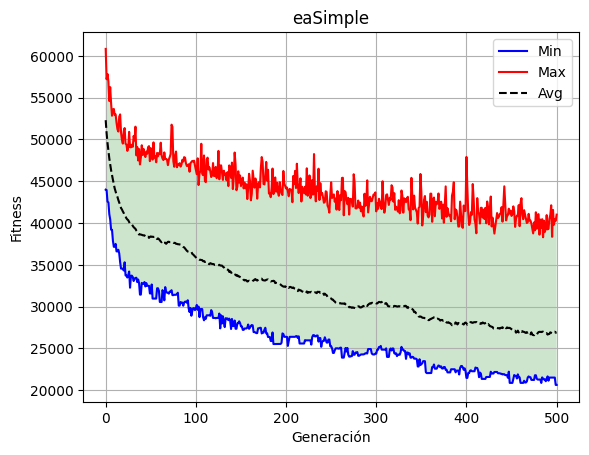

In [35]:
print("Mejor fitness: ", hof[0].fitness.values)
print("Mejor individuo: ", hof[0])
plot_evolucion(logbook, implementacion)

In [36]:
# Comparación con lo óptimo
print("Distancia Óptima: ", distancia_optima)
print("Ruta Óptima: ", ruta_optima) # Es circular, el orden es lo importante

Distancia Óptima:  6942
Ruta Óptima:  [1, 76, 59, 15, 30, 29, 120, 32, 92, 28, 45, 78, 86, 94, 81, 22, 66, 31, 117, 85, 18, 19, 25, 108, 43, 79, 52, 33, 100, 58, 91, 68, 65, 69, 113, 107, 20, 46, 50, 44, 75, 14, 87, 74, 105, 40, 72, 38, 7, 56, 41, 42, 98, 17, 118, 49, 13, 51, 11, 23, 9, 103, 119, 3, 82, 2, 115, 21, 93, 53, 64, 109, 88, 97, 12, 95, 77, 39, 63, 5, 27, 80, 101, 102, 48, 110, 112, 106, 114, 73, 57, 83, 67, 37, 62, 99, 10, 35, 104, 36, 84, 6, 89, 55, 47, 71, 26, 4, 34, 116, 70, 8, 54, 90, 96, 111, 24, 60, 16, 61]


## Extras

Se adjunta un cuadro comparativos de resultados, realizado por estudiantes de Inteligencia Computacioanl.
Pueden apreciarse diferentes configuraciones para estos problemas y los desempeños.

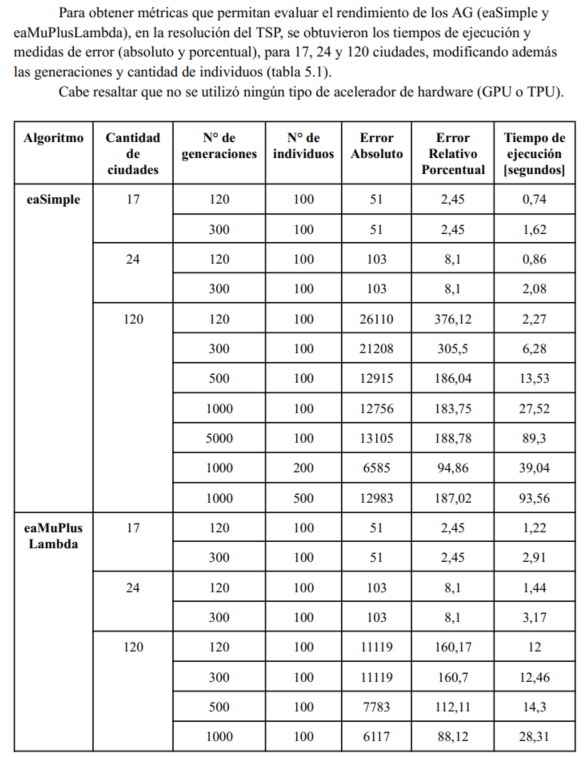